In this script implements a Generative Adversarial Network (GAN) in TensorFlow -following a StyleGAN architecture - tailored for generating anime-style images representing the style of the human face dataset. It encompasses the following key components:

- Setup and Dependencies: The code starts by mounting Google Drive for data access and installing necessary dependencies, including TensorFlow and TensorFlow Addons.

- Function Definitions: It includes several functions for loading and preprocessing images, generating new images, and building the GAN's architecture. This includes the generator and discriminator models, which are central to the GAN's operation.

- Model Training: The script outlines the process of training the GAN, including defining loss functions, optimizers, and a training loop. This section details the steps taken to train the model on the DBZ dataset.

- Image Generation and Testing: Post-training, the script demonstrates how to use the trained GAN to generate new anime-style images from a set of test images, showcasing the model's ability to create stylized renditions of the input.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /mnt/leif/littlab/users/tamjid/selfie2anime/

/content/drive/MyDrive/CIS 5810/FInal_project/selfie2anime


In [ ]:
! pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.6 MB/s eta 0:00:00


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_addons as tfa
import logging

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
import random
import sys

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
seed=123
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
logging.disable(sys.maxsize)

# Define Hyperparameters

In [ ]:
BUFFER_SIZE = 10
BATCH_SIZE = 2
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3
EPOCHS = 200
LAMBDA = 10
GAMMA = 10
noise_dim = 100

In [ ]:
train_selfie_path1 = 'trainA/'
train_selfie_path2 = 'trainB/'

In [ ]:
train_selfie_imgs1 = np.array(sorted(os.listdir(train_selfie_path1)))
train_selfie_imgs2 = np.array(sorted(os.listdir(train_selfie_path2)))

FileNotFoundError: ignored

In [ ]:


train_selfie1_imgs1 = list(train_selfie_imgs1)
train_selfie2_imgs2 = list(train_selfie_imgs2)



In [ ]:
ImageSet_1 = [(train_selfie_path1)+'/%s'%(x) for x in train_selfie1_imgs1]
ImageSet_2 = [(train_selfie_path2)+'/%s'%(x) for x in train_selfie2_imgs2]

NameError: ignored

# Define Functions

In [ ]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    image_ = tf.cast(image, tf.float32)
    return image_

In [ ]:
def resize(input_, height, width):
    img_ = tf.image.resize(input_, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img_

In [ ]:
# normalizing the images to [-1, 1]
def normalize(input_):
    image = tf.cast(input_, tf.float32)
    img_ = (image / 127.5) - 1

    return img_

In [ ]:
@tf.function()
def random_jitter(input_):
    img_ = resize(input_,IMG_HEIGHT, IMG_WIDTH)

    if tf.random.uniform(()) > 0.5:
        img_ = tf.image.flip_left_right(img_)

    return img_

In [ ]:
def load_image_train(file_):
    input_ = load(file_)
    img_ = random_jitter(input_)
    img_ = normalize(img_)

    return img_

In [ ]:
train_source = (
    tf.data.Dataset
    .from_tensor_slices((ImageSet_1))
    .map(load_image_train, num_parallel_calls=AUTOTUNE)
    .shuffle(7)
    .batch(BATCH_SIZE)
)
train_dest = (
    tf.data.Dataset
    .from_tensor_slices((ImageSet_2))
    .map(load_image_train, num_parallel_calls=AUTOTUNE)
    .shuffle(7)
    .batch(BATCH_SIZE)
)

NameError: ignored

In [ ]:
def noise_(num, filter, noise):
    noise_layer = tf.keras.layers.Dense(num*num*filter)(noise)
    #noise_layer = tfa.layers.InstanceNormalization()(noise_layer)
    #noise_layer = tf.keras.layers.ReLU()(noise_layer)

    reshape_noise = tf.keras.layers.Reshape((num, num, filter))(noise_layer)

    return reshape_noise

In [ ]:
def downsample(filters, size, stride, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
              tf.keras.layers.Conv2D(
                  filters,
                  size,
                  strides=stride,
                  padding='same',
                  kernel_initializer=initializer,
                  use_bias=False)
    )
    if apply_batchnorm:
        result.add(tfa.layers.InstanceNormalization())#tfa.layers.InstanceNormalization()

    result.add(tf.keras.layers.LeakyReLU(0.4))

    return result

In [ ]:
def upsample(filters, size, stride):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    layer = tf.keras.layers.Conv2DTranspose(
            filters,
            size,
            strides=stride,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False)

    result.add(
        layer
    )
    return result

# Define Model

In [ ]:
def Generator():
    input_encoder = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH,3])
    input_generator = tf.keras.layers.Input(shape=[noise_dim, ])
    initializer = tf.random_normal_initializer(0., 0.02)

    down_stack = [
        #downsample(32, 3, 2, apply_batchnorm=False),
        downsample(64, 3, 2,False),
        downsample(128, 3, 2),
        downsample(256, 3, 2,False),
        downsample(512, 3, 2,),
        downsample(512, 3, 2,False),
        downsample(512, 3, 2,),
     ]
    x = input_encoder
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    gen_layer = tf.keras.layers.Dense(4*4*512)(input_generator)
    gen_layer = tf.keras.layers.BatchNormalization()(gen_layer)
    gen_layer = tf.keras.layers.LeakyReLU(0.4)(gen_layer)

    reshape = tf.keras.layers.Reshape((4, 4, 512))(gen_layer)
    x = reshape
    up_stack = [
              upsample(512, 3, 2, ),
              upsample(512, 3, 2, ),
              upsample(256, 3, 2, ),
              upsample(128, 3, 2, ),
              upsample(64, 3, 2, ),

   ]

    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                      strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      activation='tanh')
    filters = [512,512,256,128,64]
    ndim = [8,16,32,64,128]
    for up, skip, dim, filt in zip(up_stack, skips, ndim, filters):
        x = up(x)
        n = noise_(dim, filt, input_generator)
        x = tf.keras.layers.concatenate([n, x])
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.4)(x)

        x = tf.keras.layers.concatenate([x, skip])

    x = last(x)
    return tf.keras.Model(inputs=[input_encoder,input_generator], outputs=x)

In [ ]:
generator = Generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 8192)                 827392    ['input_4[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 8192)                 32768     ['dense[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu_7 (LeakyReLU)   (None, 8192)                 0         ['batch_normalization[0][0

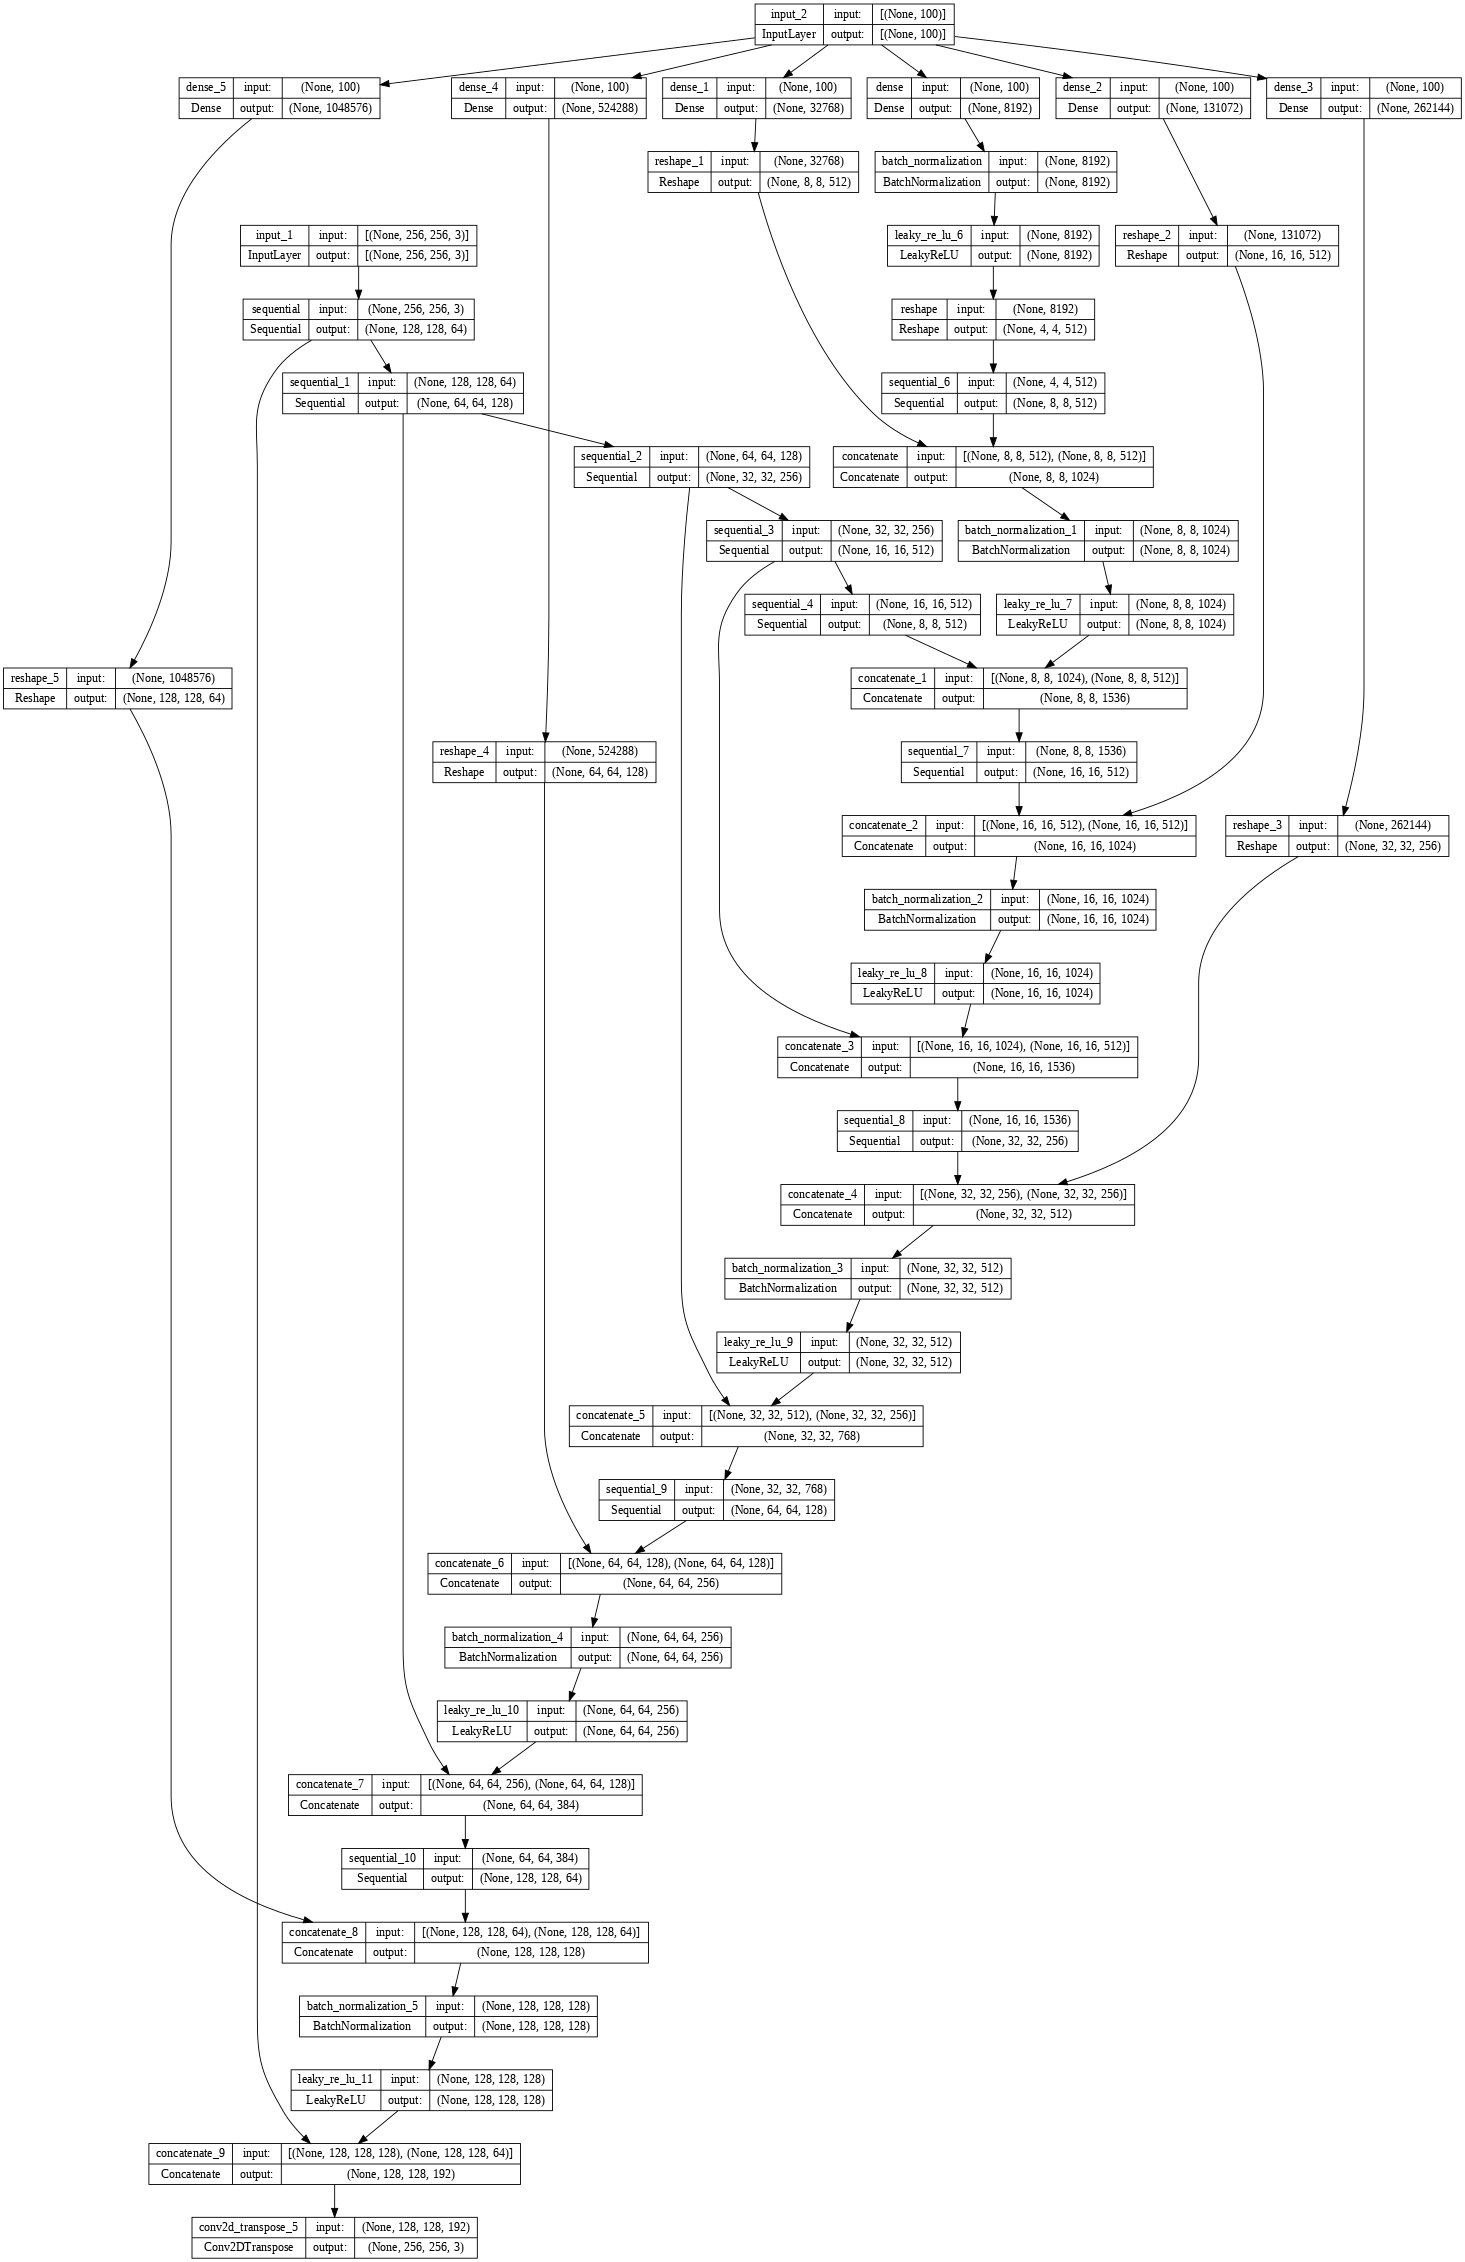

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    input_ = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='input_image')
    down1 = downsample(64, 3, 2,False)(input_)
    down2 = downsample(128, 3, 2)(down1)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2)
    conv = tf.keras.layers.Conv2D(256, 3, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv) #Itfa.layers.InstanceNormalization()

    leaky_relu = tf.keras.layers.LeakyReLU(0.4)(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

    last = tf.keras.layers.Conv2D(1, 3, strides=1,
                                kernel_initializer=initializer,
                                )(zero_pad2)
    return tf.keras.Model(inputs=input_, outputs=last)

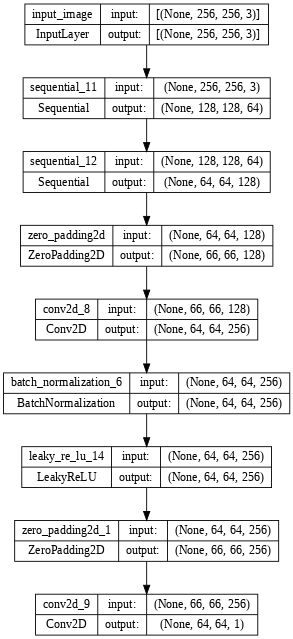

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + (generated_loss)*LAMBDA*0.5
    loss_ = (generated_loss)*LAMBDA*0.5

    return total_disc_loss, loss_

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_obj(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA *(l1_loss)*0.5)

    return total_gen_loss, gan_loss, l1_loss

In [ ]:
def reconstruction(recon_x, x):
    return tf.reduce_mean(tf.abs(recon_x - x))

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5, beta_2=0.99,epsilon=1e-08)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5, beta_2=0.99,epsilon=1e-08)

In [ ]:


def generate_images(model, input_1, input_2, noise):
    prediction = model([input_1, noise], training=True)
    plt.figure(figsize=(15,15))

    display_list = [input_1[0], input_2[0], prediction[0]]
    title = ['Source Image', 'Destination Image', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()



#Training the model

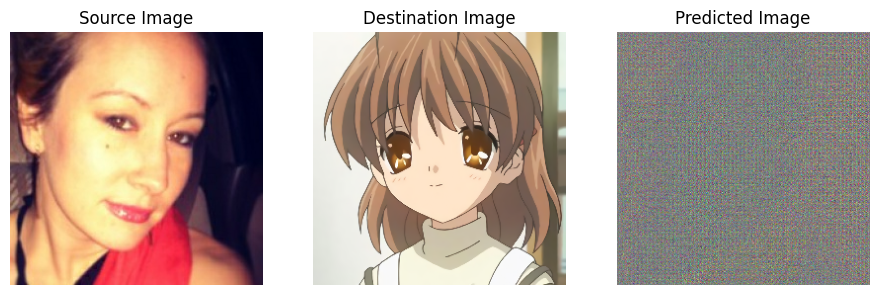

In [ ]:
example_input_1 = next(iter(train_source))
example_input_2 = next(iter(train_dest))
noise = tf.random.normal([BATCH_SIZE, noise_dim])
generate_images(generator, example_input_1, example_input_2,noise)

In [ ]:
@tf.function
def train_step(real_x, real_y, noise):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([real_x,noise], training=True)

        real_output = discriminator(real_y, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(fake_output, generated_images, real_y)

        recon_loss = reconstruction(generated_images, real_x)
        disc_loss, _ = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

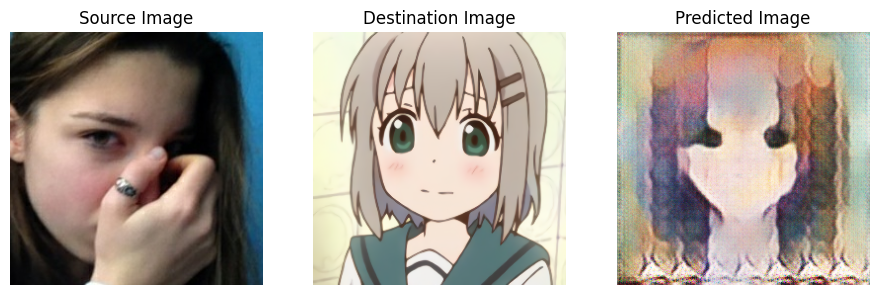

Time taken for epoch 17 is 794.1837220191956 sec

..................Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-47165deffd23>", line 6, in <cell line: 2>
    for image_x, image_y in tf.data.Dataset.zip((train_source, train_dest)):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 810, in __next__
    return self._next_internal()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 773, in _next_internal
    ret = gen_dataset_ops.iterator_get_next(
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 3029, in iterator_get_next
    _ops.raise_from_not_ok_status(e, name)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 5883, in raise_from_no

In [ ]:
result=[]
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_source, train_dest)):
        noise = tf.random.normal([BATCH_SIZE, noise_dim])
        train_step(image_x, image_y, noise)
        if n % 20 == 0:
            print ('.', end='')
        n+=1

    clear_output(wait=True)
    generate_images(generator, image_x, image_y, noise)
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))
    generator.save('generator_model_styleGAN.h5')
    if epoch>=400:
        pred = generator([image_x, noise], training=True)
        result.append(pred[0])

In [ ]:
# source = []
# dest = []
# for x,y in zip(ImageSet_1,ImageSet_2):
#     source.append(load_image_train(x))
#     dest.append(load_image_train(y))
# fig, axis = plt.subplots(2, 3, figsize=(18, 10))
# for i, ax in enumerate(axis.flat):
#     ax.imshow(source[i] * 0.5 + 0.5)
#     ax.set(title = f"Source Set")
#     ax.axis('off')

In [ ]:
# res_1 = result[:60]
# fig, axis = plt.subplots(5, 3, figsize=(25, 40))
# for i, ax in enumerate(axis.flat):
#     ax.imshow(res_1[i] * 0.5 + 0.5)
#     ax.axis('off')

(256, 256, 3)
(256, 256, 3)


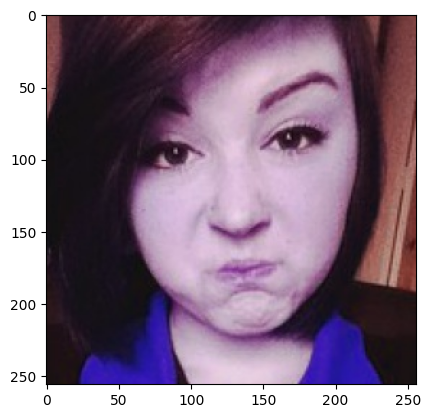

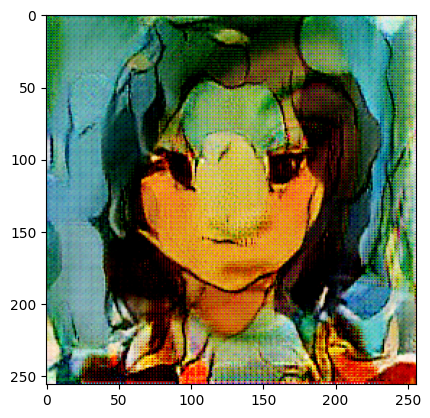

In [ ]:
gen_loaded_model = Generator()
gen_loaded_model.load_weights('/content/drive/MyDrive/generator_model_styleGAN.h5')




import cv2






data = np.array(cv2.imread('/content/drive/MyDrive/images/female_11025.jpg'))

data1 = np.array(cv2.imread('/content/drive/MyDrive/images/female_11025.jpg'))
data1 = cv2.resize(data1,(256,256))
data = cv2.resize(data,(256,256))
print(data.shape)
noise = tf.random.normal([BATCH_SIZE, noise_dim])


combined_array = np.stack((data, data1), axis=0)

print(data.shape)
# for example_input, example_target in test_dataset.take(45):
#   generate_images(gen_loaded_model, example_input, example_target)
prediction = gen_loaded_model([np.reshape(combined_array,[2,256,256,3]),noise])
plt.figure()
plt.imshow(data)
plt.figure()
plt.imshow(prediction[0])